# 3. Visualización y Comparativa de Rendimiento

Este script tiene como objetivo analizar gráficamente los datos obtenidos en la fase de evaluación. Se importan los resultados desde `metrics_comparison.csv` para generar visualizaciones que nos permitan responder a la pregunta: **¿Cómo afecta el tamaño del modelo al rendimiento en este subconjunto de datos?**

Nos centraremos en dos tipos de análisis:
1.  **Tendencias:** Visualizar cómo evolucionan las métricas a medida que aumentamos la complejidad del modelo.
2.  **Comparativa Directa:** Un desglose lado a lado de todas las métricas para cada variante.

In [62]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

Se definen los directorios que se van a emplear

In [63]:
ROOT_DIR = Path.cwd()
RESULTS_DIR = ROOT_DIR / "validation_results"

In [64]:
df_metrics = pd.read_csv(RESULTS_DIR / "metrics_comparison.csv")
df_metrics.sort_values(by="mAP@50-95", ascending=False, inplace=True)

df_metrics

,Modelo,Precision,Recall,F1-Score,mAP@50,mAP@50-95,Avg Inference Time (ms)
0,yolov8x.pt,0.721,0.683,0.702,0.805,0.617,575.3247
1,yolov8l.pt,0.734,0.660,0.695,0.794,0.617,452.6824
2,yolov8m.pt,0.688,0.665,0.677,0.777,0.596,232.8931
3,yolov8s.pt,0.692,0.608,0.648,0.694,0.537,97.4258
4,yolov8n.pt,0.716,0.555,0.625,0.625,0.456,49.4698


### Tendencias de Rendimiento: Métricas Manuales vs. Estándar COCO

En la siguiente gráfica superponemos todas las métricas calculadas.
* **Líneas Punteadas:** Representan nuestras métricas calculadas manualmente (Precisión y Recall) a un umbral de confianza fijo.
* **Línea Azul Sólida:** Muestra el F1-Score, que es el balance armónico entre precisión y recall.
* **Líneas Sólidas Gruesas (Naranja/Verde):** Representan el mAP (Mean Average Precision), que es la métrica más robusta ya que evalúa el modelo en múltiples umbrales de confianza.

**Interpretación:** Buscamos observar si existe una correlación directa entre el aumento del tamaño del modelo (eje X) y la mejora en las métricas (eje Y).

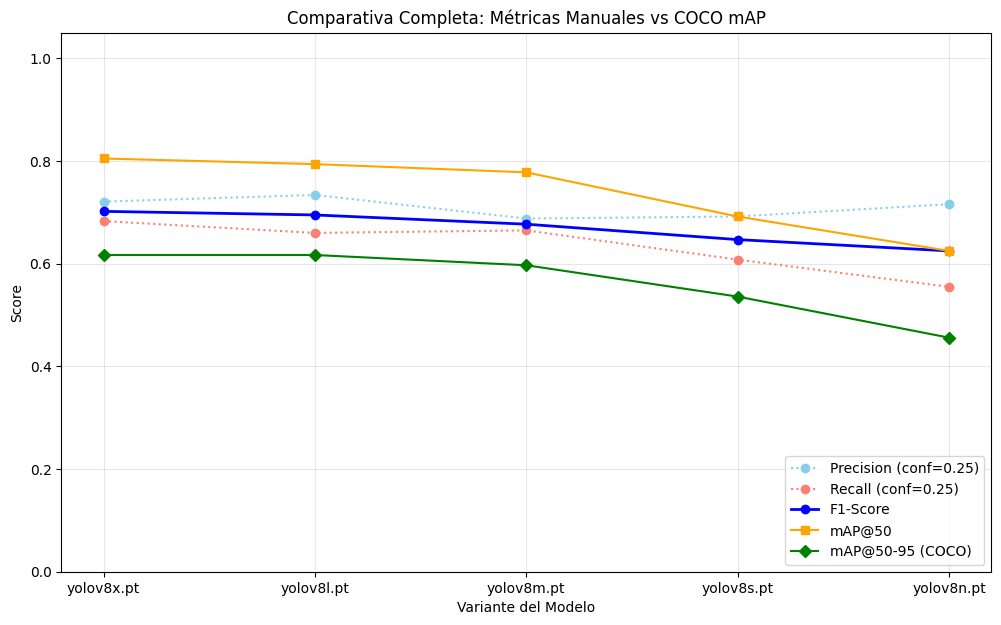

In [69]:
# Métricas Manuales (Líneas punteadas)
plt.figure(figsize=(12, 7))

plt.plot(df_metrics['Modelo'], df_metrics['Precision'], marker='o', linestyle=':', color='skyblue', label='Precision (conf=0.25)')
plt.plot(df_metrics['Modelo'], df_metrics['Recall'], marker='o', linestyle=':', color='salmon', label='Recall (conf=0.25)')
plt.plot(df_metrics['Modelo'], df_metrics['F1-Score'], marker='o', linestyle='-', linewidth=2, color='blue', label='F1-Score')

# Métricas mAP (Líneas sólidas gruesas)
plt.plot(df_metrics['Modelo'], df_metrics['mAP@50'], marker='s', linestyle='-', color='orange', label='mAP@50')
plt.plot(df_metrics['Modelo'], df_metrics['mAP@50-95'], marker='D', linestyle='-', color='green', label='mAP@50-95 (COCO)')
plt.title('Comparativa Completa: Métricas Manuales vs COCO mAP')
plt.xlabel('Variante del Modelo')
plt.ylabel('Score')
plt.legend(loc='lower right', frameon=True)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05) # Fijar eje Y de 0 a 1
plt.savefig(RESULTS_DIR / "lines_comparison.png", dpi=300)
plt.show()



### Desglose Detallado por Modelo

Este gráfico de barras agrupadas permite una comparación granular. Para cada modelo (eje X), observamos la altura de las barras correspondientes a cada métrica.

Esto es útil para detectar casos específicos, por ejemplo:
* Un modelo que tenga muy buen mAP pero bajo Recall (indicaría que es preciso pero se deja objetos sin detectar).
* Comparar visualmente qué salto de rendimiento es mayor: ¿de Nano a Small, o de Medium a Large?

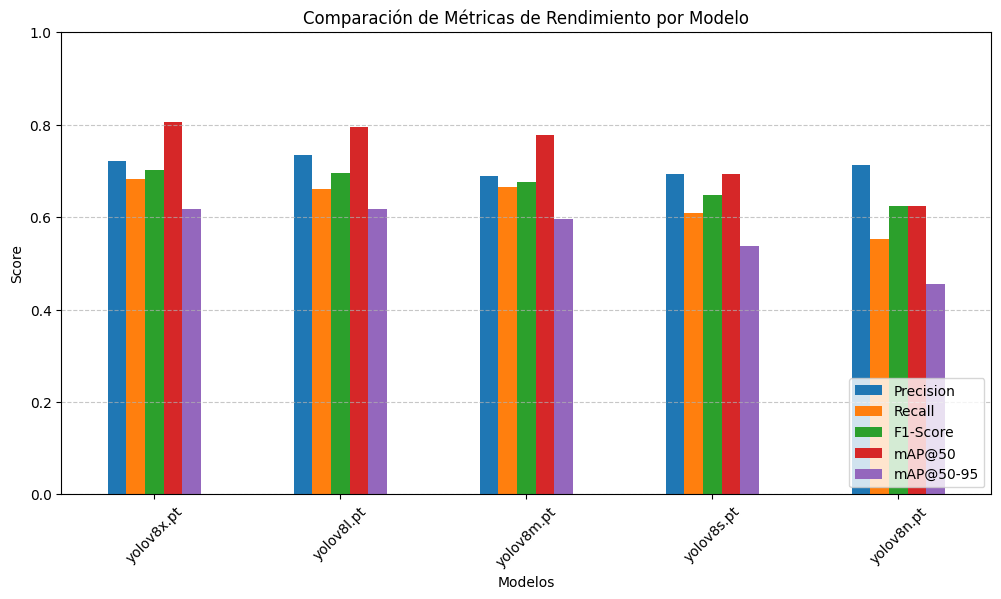

In [70]:
# Gráfico de barras para métricas excepto tiempo de inferencia
metrics_cols = ['Precision', 'Recall', 'F1-Score', 'mAP@50', 'mAP@50-95']
df_metrics.plot(x='Modelo', y=metrics_cols, kind='bar', figsize=(12, 6))
plt.title('Comparación de Métricas de Rendimiento por Modelo')
plt.ylabel('Score')
plt.xlabel('Modelos')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)
plt.savefig(RESULTS_DIR / "bar_comparison.png", dpi=300)
plt.show()

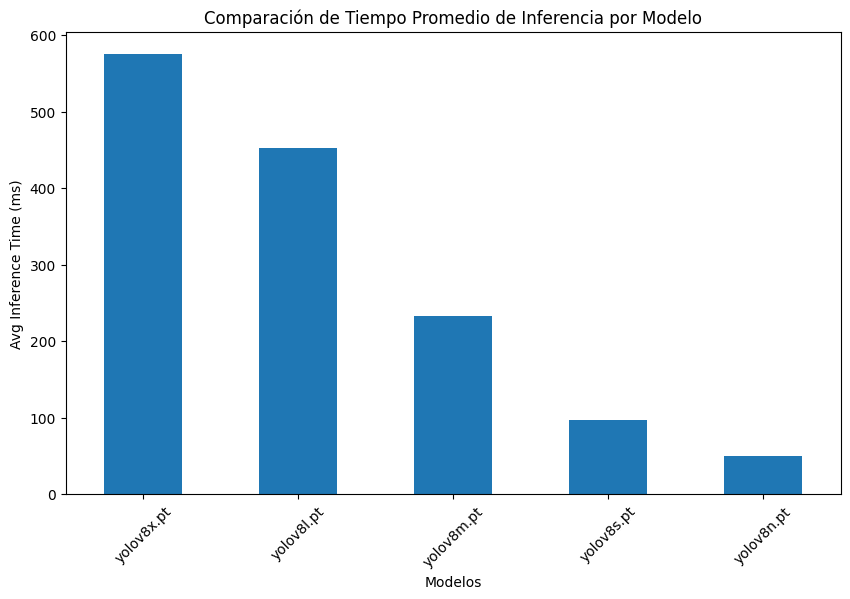

In [71]:
# Gráfico de barras comparativo de los tiempos de inferencia medios
df_metrics.plot.bar(x='Modelo', y='Avg Inference Time (ms)', figsize=(10, 6), legend=False)

plt.title('Comparación de Tiempo Promedio de Inferencia por Modelo')
plt.ylabel('Avg Inference Time (ms)')
plt.xlabel('Modelos')
plt.xticks(rotation=45)
plt.savefig(RESULTS_DIR / "inference_time_comparison.png", dpi=300)
plt.show()

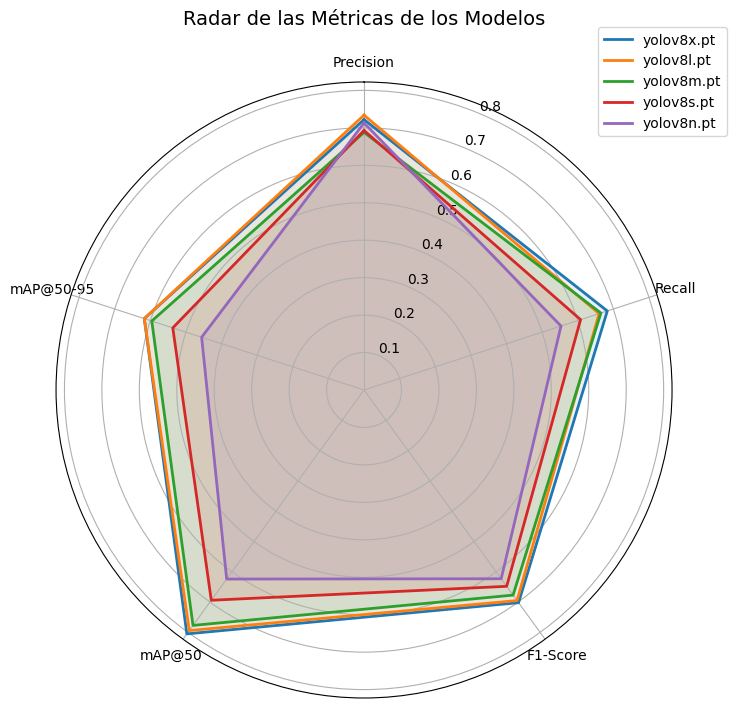

In [ ]:
# Gráfico de radar
labels = df_metrics.columns[1:-1]  # Excluir 'Modelo' y 'Avg Inference Time (ms)'
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] # Cerrar el círculo

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] 

for i, (index, row) in enumerate(df_metrics.iterrows()):
    model_name = row['Modelo']
    values = row[labels].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name, color=colors[i % len(colors)])
    ax.fill(angles, values, color=colors[i % len(colors)], alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('Radar de las Métricas de los Modelos', y=1.08, fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.savefig(RESULTS_DIR / "radar_comparison.png", dpi=300)
plt.show()